# A FastAI Kaggle Walkthrough - Framework for Tinkering

#### A quick starter kit for FastAI library users

FASTAI is a custom deep learning library designed with the latest techniques and is currently under development. It is being used as a rapid deployment machine learning framework. The repo can be found here:

https://github.com/fastai/fastai


### Installation 
```bash

git clone https://github.com/fastai/fastai
cd fastai
conda env update
source activate fastai
```

### Followed tutorial similar to lesson 1:

```bash
https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
```
### Credit: Adapted material from Prince's notebook (.2094)
https://www.kaggle.com/grroverpr/cnn-using-fastai-lb-0-2094

https://github.com/groverpr/deep-learning/blob/master/image_comp_1_2.ipynb

### Color composite work from Kerem

https://www.kaggle.com/keremt/getting-color-composites



## 1. Importing Libraries

**OS Libraries** - We will need some basic OS level libraries to move the files around. The FastAI library looks for a particular folder structure

**Image libraries** - Allow us to manipulate and convert images to arrays and vice versa. In the simplest case we will be pulling out 75x75 matrices in 2 bands and then treating them as images. These libraries can later be used for advanced techniques such as filtering or touching up the photo. 

#### Torch is imported earlier because of TLS memory errors on some computers


```python
import torch
```


```python
import shutil
import os
import sys
sys.path.append('../repos/fastai/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
from scipy.ndimage import filters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
```

## 1.1 Importing FastAI Libraries

#### The fastAI library is built on top of pytorch to take advange of the GPU power.




```python
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
```

#### Checks to make sure you are using the GPU, will get error if none found


```python
torch.cuda.set_device(0)
```


## 2. Data Prep


```python
train_df = pd.read_json('../Desktop/data/iceberg/data/processed/train.json')
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'],errors='coerce')
```


```python
print(train_df.shape)
```

    (1604, 5)


### 2.1 Organizing Folders + Files for the Fastai Library

- To use the FastAI library there are a few requirements:
- set up your folders correctly with proper names
- and pass the parameter `test_name` when running the model (see section 3)
- Will save the images into two different folders `test` and `train\ships` and `train\iceberg`


```python
PATH = 'iceberg_data/'
```

#### Set the File Locations

**`train`** - should have a folder for each class that wants to be identified. In this case there is only two `ship` and `iceberg`, but any number of classifications could be used by adding more folders.

**`valid`** - mirrors the two `ship` and `iceberg`, folders. This should contain your validation set you are considering to use.

**`test`** - doesn't have to be called test, but remember the folder name when the model is called later




```python
shipPATH = 'iceberg_data/train/ship/'
icebergPATH = 'iceberg_data/train/iceberg/'
shipVALID = 'iceberg_data/valid/ship/'
icebergVALID = 'iceberg_data/valid/iceberg/'
testPATH = 'iceberg_data/test/'
```

#### Cleanup the existing folders ( drop all the files)

These short commands clears out the folders so that files aren't double generated


```python
shutil.rmtree(shipPATH)
os.mkdir(shipPATH)

shutil.rmtree(icebergPATH)
os.mkdir(icebergPATH)

shutil.rmtree(shipVALID)
os.mkdir(shipVALID)

shutil.rmtree(icebergVALID)
os.mkdir(icebergVALID)

shutil.rmtree(testPATH)
os.mkdir(testPATH)

os.makedirs('tmp', exist_ok=True)
```

### 2.2 Image creation (to Jpegs)

#### Creating the training dataset in `train\iceberge` and `train\ship`

#### Load the input json


```python
train_df.shape
```




    (1604, 5)




```python
icebergs = train_df[train_df.is_iceberg==1]#.sample(n=9,random_state=123)
ships = train_df[train_df.is_iceberg==0]#.sample(n=9,random_state=456)
```

#### Pull out the different Bands

For every picture there are 2 bands. For illustrative purposes we are treating them as different pictures to increase the dataset size. Some further development of combining the two matrices is possible

https://www.kaggle.com/keremt/getting-color-composites


```python
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
#         r = ((band_1 - np.mean(band_1)) / (np.max(band_1) - np.min(band_1))) 
#         g = ((band_2 - np.mean(band_2)) / (np.max(band_2) - np.min(band_2))) 
#         b = ((band_3 - np.mean(band_3)) / (np.max(band_3) - np.min(band_3)))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)
```


```python
icebergs_picts = color_composite(icebergs)
ships_picts = color_composite(ships)
```


```python
icebergs_picts.shape
```




    (753, 75, 75, 3)




```python
plt.imshow(icebergs_picts[0])
```




    <matplotlib.image.AxesImage at 0x7ff0cb1a9668>



![output_27_1.png](attachment:output_27_1.png)
![png](output_27_1.png)



#### Functions to save to disk

These two functions turn the long raveled vectors into matrices, and then save them to `.png` files with matplotlib


```python
import matplotlib 

def vect2Matrix(vect):
    return np.reshape(np.array(vect),(75,75))

def saveMatrix(array, filename):
    matplotlib.image.imsave(filename, array)
```

#### Saving each training set `.png` to the respective Folders

Loops through all the different datasets and saves them to disk


```python
for i, x in enumerate(icebergs_picts):
    matplotlib.image.imsave('iceberg_data/train/iceberg/iceberg_%d.png' % i, x)
```


```python
for i, x in enumerate(ships_picts):
    matplotlib.image.imsave('iceberg_data/train/ship/ship_%d.png' % i, x)
```

#### creating the testset files in the `test` directory


```python
test_df = pd.read_json('../Desktop/data/iceberg/data/processed/test.json')
```


```python
test_df.head()
```




<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>band_1</th>
      <th>band_2</th>
      <th>id</th>
      <th>inc_angle</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>[-15.863251, -15.201077, -17.887735, -19.17248...</td>
      <td>[-21.629612, -21.142353, -23.908337, -28.34524...</td>
      <td>5941774d</td>
      <td>34.966400</td>
    </tr>
    <tr>
      <th>1</th>
      <td>[-26.058969497680664, -26.058969497680664, -26...</td>
      <td>[-25.754207611083984, -25.754207611083984, -25...</td>
      <td>4023181e</td>
      <td>32.615072</td>
    </tr>
    <tr>
      <th>2</th>
      <td>[-14.14109992980957, -15.064241409301758, -17....</td>
      <td>[-14.74563980102539, -14.590410232543945, -14....</td>
      <td>b20200e4</td>
      <td>37.505433</td>
    </tr>
    <tr>
      <th>3</th>
      <td>[-12.167478, -13.706167, -16.54837, -13.572674...</td>
      <td>[-24.32222, -26.375538, -24.096739, -23.8769, ...</td>
      <td>e7f018bb</td>
      <td>34.473900</td>
    </tr>
    <tr>
      <th>4</th>
      <td>[-23.37459373474121, -26.02718162536621, -28.1...</td>
      <td>[-25.72234344482422, -27.011577606201172, -23....</td>
      <td>4371c8c3</td>
      <td>43.918874</td>
    </tr>
  </tbody>
</table>
</div>




```python
test_picts = color_composite(test_df)
```

#### Saving the test `.png` files to disk


```python
for i, x in zip(test_df['id'],test_picts):
    matplotlib.image.imsave('iceberg_data/test/im_%s.png' % i, x)
```

#### memory clean up 

(will work off the files in the disk, will delete variables in RAM)


```python
del train_df, test_df, icebergs_picts, ships_picts, icebergs, ships, test_picts
```

### Image Processing (adding blur)


```python
ice_bergs = os.listdir('iceberg_data/train/iceberg/')
ships = os.listdir('iceberg_data/train/ship/')
test = os.listdir('iceberg_data/test/')
```


```python
for x in ice_bergs:
    pp = Image.open('iceberg_data/train/iceberg/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('iceberg_data/train/iceberg/'+x)
print('processing icebergs')
    
for x in ships:
    pp = Image.open('iceberg_data/train/ship/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('iceberg_data/train/ship/'+x)
print('processing ships')
    
for x in test:
    pp = Image.open('iceberg_data/test/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('iceberg_data/test/'+x)
print('processing test')
    
```

    processing icebergs
    processing ships
    processing test


### 2.2 Create a random validation set ( from the training set)


```python
# get the list of the directory
allships = os.listdir(shipPATH)
iceberg = os.listdir(icebergPATH)

# check how many files
print(len(allships),len(iceberg))

sample_iceberg = np.random.choice(iceberg, size=150)
sample_iceberg = list(set(sample_iceberg))
sample_allships = np.random.choice(allships, size=150)
sample_allships = list(set(sample_allships))
```

    712 614


#### Move the files from training to the test folder


```python
for x in sample_iceberg:
    shutil.move(icebergPATH+x, icebergVALID+x)
    
for x in sample_allships:
    shutil.move(shipPATH+x, shipVALID+x)
```

#### Check that training files have moved into validation


```python
allships = os.listdir(shipPATH)
iceberg = os.listdir(icebergPATH)

# check how many files
print(len(allships),len(iceberg))
```

    573 477


#### Check size of test set


```python
len(os.listdir(testPATH))
```




    8424







### 3. Try a basic `fastai` CNN network (runs 10mins on 8 core, 30 GB, P5000 GPU, paperspace)

**`ImageClassifierData`** is an instance that looks at the folder structure and takes care of labeling and grouping between the training, validation and test sets.

**`test_name`** = be sure to put the name of your test folder here. It doesn't have to be `'test'` but it should be consistent with whatever you named your folder. 

**`ConvLearner`** is the CNN neural network we wil lbe training. 


```python
%%time

sz = 60
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=32, test_name='test')
learn = ConvLearner.pretrained(arch, data)
learn.fit(0.01, 3)
```


    A Jupyter Widget


    [ 0.    0.29  0.51  0.77]                                  
    [ 1.    0.37  0.48  0.78]                                  
    [ 2.    0.39  0.49  0.79]                                  
    
    CPU times: user 2.17 s, sys: 4.14 s, total: 6.31 s
    Wall time: 6.66 s


#### Which is the iceberg column?


```python
data.classes
```




    ['iceberg', 'ship']




```python
lrf = learn.lr_find()
```


    A Jupyter Widget


     76%|███████▌  | 25/33 [00:00<00:00, 49.85it/s, loss=1.66] 
                                                              


```python
learn.sched.plot_lr()
```

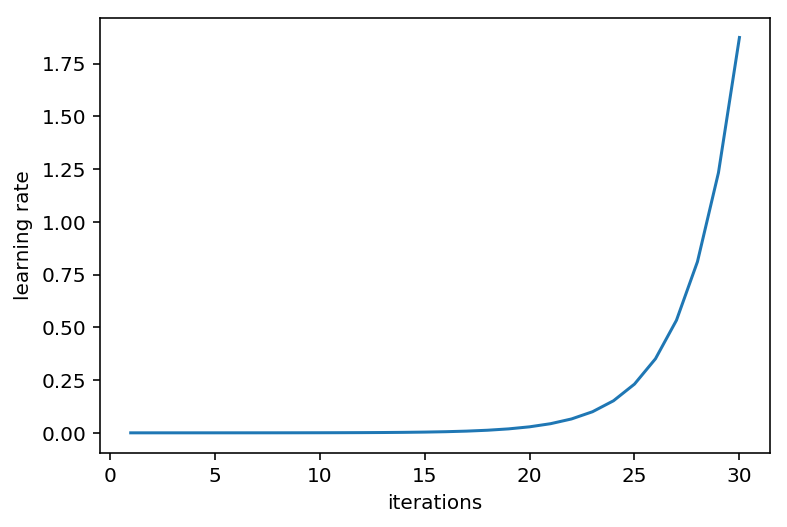
![png](output_55_0.png)



```python
learn.sched.plot()
```

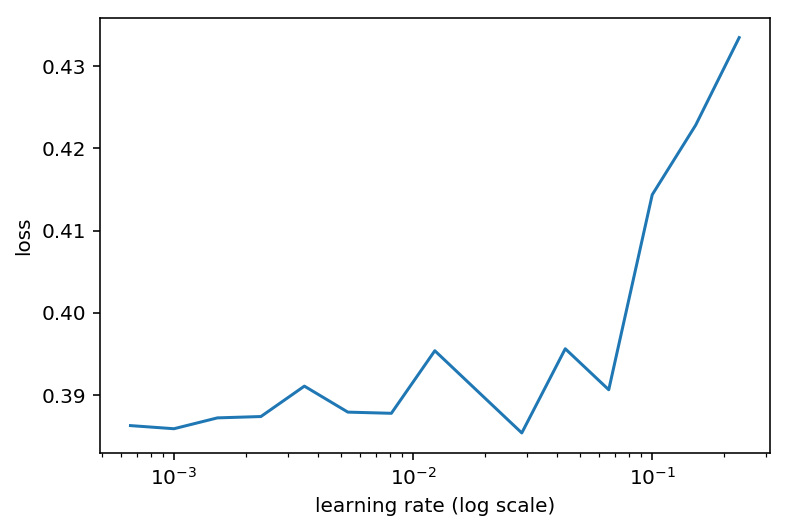
![png](output_56_0.png)



```python
lr = 0.01
```


```python
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # precompute was false # first fit
```


    A Jupyter Widget


    [ 0.       0.19107  0.50574  0.77847]                      
    [ 1.       0.28283  0.48702  0.80104]                      
    [ 2.       0.31705  0.51333  0.78854]                      
    [ 3.       0.35077  0.55805  0.79236]                      
    [ 4.       0.358    0.49079  0.7816 ]                      
    [ 5.       0.33872  0.47646  0.79583]                      
    [ 6.       0.32055  0.48282  0.78507]                      
    



```python
# stochastic descent with restart
learn.sched.plot_lr()

```

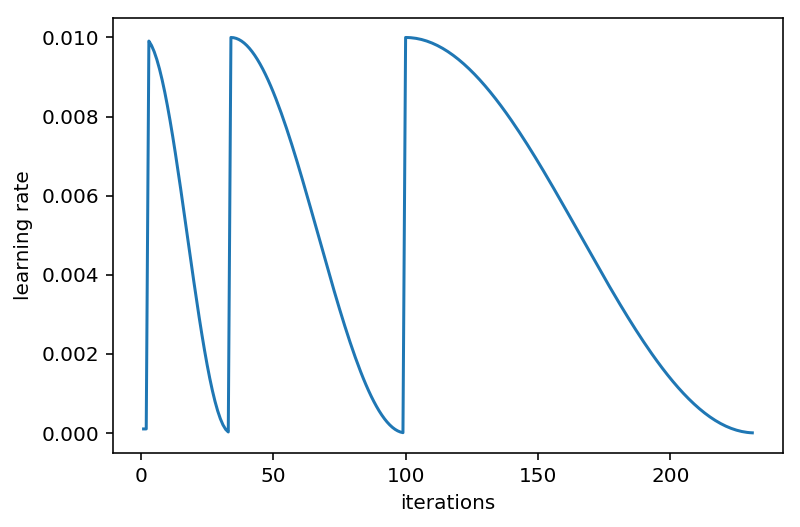
![png](output_59_0.png)



```python
learn.sched.plot_loss()

```

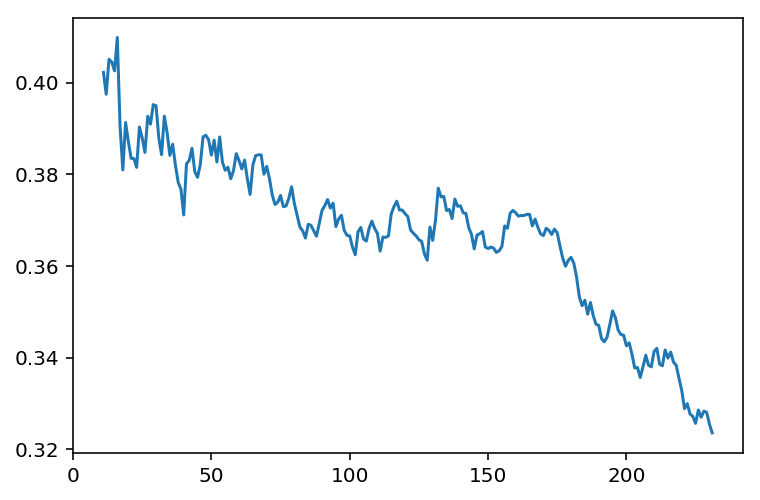
![png](output_60_0.png)



```python
lr = 0.01
```


```python
learn.unfreeze()
```


```python
lrs=np.array([lr/8,lr/4,lr]) # use lr/100 and lr/10 respectively if images would have been larger in sizes
```


```python
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
```


    A Jupyter Widget


    [ 0.       0.12825  0.52257  0.78924]                      
    [ 1.       0.19451  0.523    0.79236]                      
    [ 2.       0.2258   0.51968  0.79931]                      
    [ 3.       0.24673  0.512    0.78021]                      
    [ 4.       0.26279  0.51314  0.79792]                      
    [ 5.       0.26421  0.50917  0.79097]                      
    [ 6.       0.25516  0.50997  0.7875 ]                      
    



```python
learn.sched.plot_loss()
```

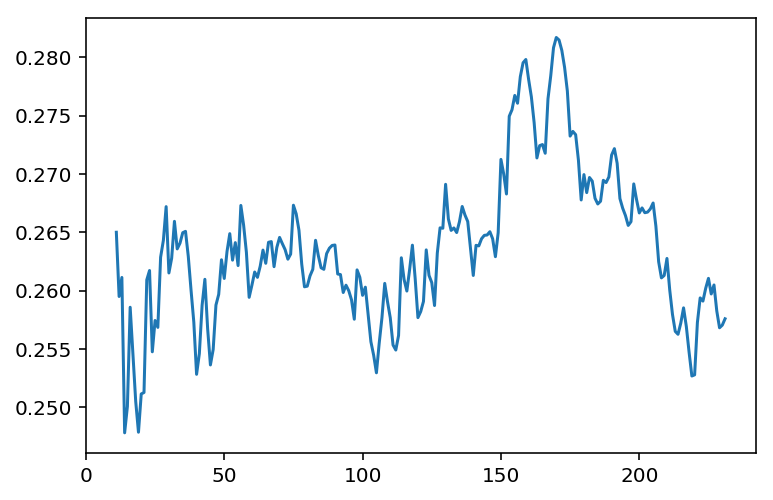
![png](output_65_0.png)



### 3.1 Test Data


```python
data.classes
```




    ['iceberg', 'ship']




```python
%%time
log_preds,y = learn.TTA(is_test=True)
```

    CPU times: user 20.7 s, sys: 15.9 s, total: 36.6 s
    Wall time: 39.1 s



```python
ice_preds = np.exp(log_preds)
```


```python
df = pd.DataFrame(ice_preds)
df.columns = data.classes
```

#### insert ids


```python
data.test_ds.fnames[:10]
```




    ['test/im_73a0734f.png',
     'test/im_7b8ec14a.png',
     'test/im_4ba6023f.png',
     'test/im_8915b349.png',
     'test/im_e97daf2c.png',
     'test/im_645ae5b9.png',
     'test/im_5a599eb7.png',
     'test/im_1286ea75.png',
     'test/im_49c670ad.png',
     'test/im_d85dae3b.png']




```python
df.insert(0,'id',[y.split('/')[-1].split('_')[-1].split('.')[0] for y in data.test_ds.fnames ] )
```


```python
df.head()
```




<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>iceberg</th>
      <th>ship</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>73a0734f</td>
      <td>0.022000</td>
      <td>0.978000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>7b8ec14a</td>
      <td>0.035137</td>
      <td>0.964863</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4ba6023f</td>
      <td>0.998345</td>
      <td>0.001655</td>
    </tr>
    <tr>
      <th>3</th>
      <td>8915b349</td>
      <td>0.214657</td>
      <td>0.785343</td>
    </tr>
    <tr>
      <th>4</th>
      <td>e97daf2c</td>
      <td>0.003339</td>
      <td>0.996661</td>
    </tr>
  </tbody>
</table>
</div>




```python
sub = df[['id','iceberg']]
sub.columns = ['id','is_iceberg']
```


```python
sub.to_csv('iceberg_sub2.csv', index=False)
```


```python
FileLink('iceberg_sub2.csv')
```







## Validation Analysis (TBD)


```python
data.classes
```




    ['iceberg', 'ship']



#### Look at the validation set


```python
y_true = data.val_y
y_true.shape
```




    (554,)



#### Look at the initial validation scores


```python
log_preds = learn.predict()
log_preds.shape
```




    (554, 2)




```python
log_preds[:10]
```




    array([[-0.89929, -0.52232],
           [-0.00083, -7.09592],
           [-0.16521, -1.88199],
           [-0.31109, -1.31918],
           [-0.82572, -0.57611],
           [-0.04664, -3.08843],
           [-0.00466, -5.37201],
           [-0.29146, -1.37504],
           [-1.83121, -0.17462],
           [-1.24911, -0.33794]], dtype=float32)




```python
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(ship)
probs[:10]
```




    array([ 0.59314,  0.00083,  0.15229,  0.26735,  0.56208,  0.04557,  0.00464,  0.25283,  0.83978,  0.71324], dtype=float32)




```python
preds.shape
```




    (554,)




```python

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['iceberg','ship'],
                      title='Confusion matrix, without normalization')

```

    Confusion matrix, without normalization
    [[221  55]
     [ 63 215]]


![output_84_1.png](attachment:output_84_1.png)
![png](output_84_1.png)


## Future Improvements

## Apply Filters


```python
def preprocess(img):
    img_array = np.array(img)
    img = img.filter(ImageFilter.MedianFilter(5))
    img = img.filter(ImageFilter.SHARPEN)
    img = img.filter(ImageFilter.DETAIL)    
    
    post_array = np.array(img)
    fig = plt.figure(1,figsize=(10,8))
    
    ax = fig.add_subplot(2,2,1)
    ax.imshow(img_array)
    ax = fig.add_subplot(2,2,2)
    ax.imshow(post_array)
    return post_array

def saveNpAsImg(npimg):
    PILIMG = Image.fromarray(img_array)

```


```python
img = Image.open('iceberg_data/valid/ship/ship_band1_20.png')
tt = preprocess(img)
```

![output_88_0.png](attachment:output_88_0.png)
![png](output_88_0.png)



```python
img = Image.open('iceberg_data/valid/iceberg/iceberg_band1_12.png')
tt = preprocess(img)
```

![output_89_0.png](attachment:output_89_0.png)
![png](output_89_0.png)